In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
path = '/Users/kai/Desktop/qs/data_csv_distinct_0606'
os.chdir(path)
df = pd.read_csv('000001.SZ.csv')
df = df[['TRADE_DT', 'S_DQ_CLOSE', 'S_DQ_VOLUME', 'S_DQ_PCTCHANGE']]
df['up_flag'] = df['S_DQ_PCTCHANGE'].apply(lambda x: 1 if x > 0 else 0)
df['up_flag'] = df['up_flag'].astype('bool')
# 把日期转换成datetime格式
df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'], format='%Y%m%d')
df_turn = pd.read_csv('/Users/kai/Desktop/qs/turn_wind/000001.SZ.CSV', encoding='gbk')
df_turn = df_turn[['日期', '换手率(%)']]
df_turn.columns = ['日期', '换手率']
df_turn['日期'] = pd.to_datetime(df_turn['日期'], format='%Y-%m-%d')
# 换手率数据是字符串，需要转换成数值
df_turn['换手率'] = pd.to_numeric(df_turn['换手率'], errors='coerce')
# 把换手率数据匹配进df
df = pd.merge(df, df_turn, left_on='TRADE_DT', right_on='日期', how='left')
df = df[['TRADE_DT', 'S_DQ_CLOSE', '换手率', 'S_DQ_VOLUME', 'up_flag']]

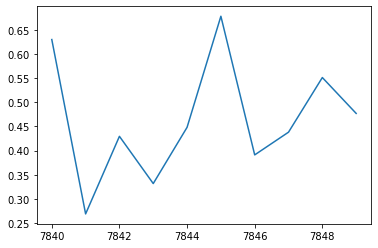

In [5]:
# 可视化df_turn最后100天的换手率
plt.plot(df_turn['换手率'][-10:])

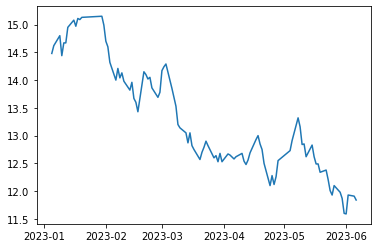

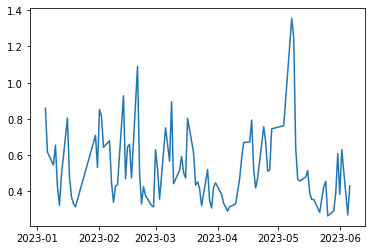

In [6]:
# 可视化df最后100天的收盘价
plt.plot(df['TRADE_DT'][-100:], df['S_DQ_CLOSE'][-100:])
plt.show()
# 可视化df最后100天的换手率
plt.plot(df['TRADE_DT'][-100:], df['换手率'][-100:])
plt.show()

In [10]:
'''
高点：
满足以下条件的日期T价格为高点：

- T涨，T+1跌
- T-1, T, T+1三天中至少一天为高量能 (高量能的定义：<u>单日成交量</u> > <u>成交量10日</u>均值的r%，r为超参数，常取0.1)
- T-1, T, T+1三天中至少一天换手率较前一天上涨超过30%

低点：
满足以下条件的日期T价格为高点：

- T跌
- T-1, T, T+1三天中至少一天为低量能 (低量能的定义：<u>单日成交量</u> < <u>成交量10日</u>均值的r%，r为超参数，常取0.1)
- T-1, T, T+1三天中至少一天换手率较前一天下跌超过30%
'''

# 根据上述规则写一个函数，判断一支股票数据的所有高低点，输出为一个dataframe
def high_low_points(df, r=0.1):
    '''
    :param df: 包含日期、收盘价、换手率的dataframe
    :param r: 超参数
    :return: 包含高低点的dataframe
    '''
    # 按照日期升序排列
    df = df.sort_values(by='TRADE_DT')
    # 计算成交量10日均值
    df['成交量10日均值'] = df['S_DQ_VOLUME'].rolling(10).mean()
    df.dropna(inplace=True)
    # 计算T-1, T, T+1三天中至少一天换手率较前一天上涨超过30%
    df['T-1, T, T+1三天中至少一天换手率较前一天上涨超过30%'] = (df['换手率'].shift(1) > df['换手率'].shift(2) * 1.3) | (df['换手率'].shift(-1) > df['换手率'].shift(1) * 1.3) | (df['换手率'] > df['换手率'].shift(1) * 1.3)
    # 计算T-1, T, T+1三天中至少一天换手率较前一天下跌超过30%
    df['T-1, T, T+1三天中至少一天换手率较前一天下跌超过30%'] = (df['换手率'].shift(1) < df['换手率'].shift(2) * 0.7) | (df['换手率'].shift(-1) < df['换手率'].shift(1) * 0.7) | (df['换手率'] < df['换手率'].shift(1) * 0.7)
    # 计算成交量高于成交量10日均值r%
    df['成交量高于成交量10日均值1+r%'] = df['S_DQ_VOLUME'] > df['成交量10日均值'] * (1 + r)
    # 计算成交量低于成交量10日均值r%
    df['成交量低于成交量10日均值1-r%'] = df['S_DQ_VOLUME'] < df['成交量10日均值'] * (1 - r)
    # 利用up_flag计算T-1涨，T+1跌
    df['T涨, T+1跌'] = df['up_flag'] & ~df['up_flag'].shift(-1).fillna(False)
    # 计算T-1跌
    df['T跌'] = ~df['up_flag'].fillna(False)
    # 计算T-1, T, T+1三天中至少一天为高量能
    df['T-1, T, T+1三天中至少一天为高量能'] = df['成交量高于成交量10日均值1+r%'].shift(1) | df['成交量高于成交量10日均值1+r%'] | df['成交量高于成交量10日均值1+r%'].shift(-1)
    # 计算T-1, T, T+1三天中至少一天为低量能
    df['T-1, T, T+1三天中至少一天为低量能'] = df['成交量低于成交量10日均值1-r%'].shift(1) | df['成交量低于成交量10日均值1-r%'] | df['成交量低于成交量10日均值1-r%'].shift(-1)
    # 计算高点
    df['高点'] = df['T涨, T+1跌'] & df['T-1, T, T+1三天中至少一天为高量能'] & df['T-1, T, T+1三天中至少一天换手率较前一天上涨超过30%']
    # 计算低点
    df['低点'] = df['T跌'] & df['T-1, T, T+1三天中至少一天为低量能'] & df['T-1, T, T+1三天中至少一天换手率较前一天下跌超过30%']
    return df

df = high_low_points(df)

In [13]:
df['高点'].sum()
# result.head(20) 

680

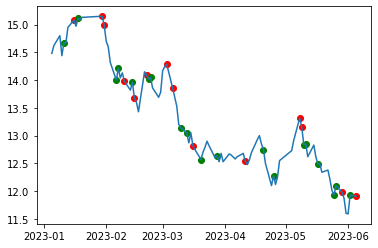

In [11]:
# 绘制result最后100天的收盘价（蓝色实线），高点（红色圆圈），低点（绿色圆圈）
t = -100
t1 = -1
# import matplotlib.pyplot as plt
plt.plot(df['TRADE_DT'][t:t1], df['S_DQ_CLOSE'][t:t1])
plt.scatter(df['TRADE_DT'][t:t1][df['高点'][t:t1]], df['S_DQ_CLOSE'][t:t1][df['高点'][t:t1]], c='r')
plt.scatter(df['TRADE_DT'][t:t1][df['低点'][t:t1]], df['S_DQ_CLOSE'][t:t1][df['低点'][t:t1]], c='g')
plt.show()